# Daniel Lupercio STAT 725 - HW1
## February 20, 2022

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


### Chapter 10, Exercise 10. 
Train a deep MLP on the MNIST dataset (you can load it using
keras.datasets.mnist.load_data(). See if you can get over
98% precision. Try searching for the optimal learning rate by using
the approach presented in this chapter (i.e., by growing the learning
rate exponentially, plotting the error, and finding the point where
the error shoots up). Try adding all the bells and whistles—save
checkpoints, use early stopping, and plot learning curves using
TensorBoard


In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [3]:
# tf.keras.datasets.mnist.load_data(path = 'mnist.npz')
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data(path = 'mnist.npz')
print(X_train_full.dtype)
print()
print(X_train_full.shape)

uint8

(60000, 28, 28)


In [4]:
X_train, X_valid = train_test_split(X_train_full, train_size=0.7, random_state=4958) 
X_valid = X_valid/255.
X_train = X_train/255.
X_test = X_test/255.
# y_valid, y_train = y_train_full[:5000], y_train_full[5]

The training set contains 42,000 images. The test set contains 10,000 images. The validation set contains 18,000 images. These three datasets equate to 60,000. Which is the total number of images in the X_train_full set.

In [6]:
print(X_valid.dtype)
print()
print(X_train.shape)
print()
print(X_valid.shape)
print()
print(X_test.shape)

float64

(42000, 28, 28)

(18000, 28, 28)

(10000, 28, 28)


I will apply the same code to a y_validation, and y_train sets. These sets do not need to be divided by 255, to get a 0-1 range, they will remain as unit8

In [7]:
y_train, y_valid = train_test_split(y_train_full, train_size=0.7, random_state=4958) 
y_valid = y_valid
y_train = y_train
y_test = y_test

In [8]:
print(y_valid.dtype)
print(y_valid.shape) #validation set contians 18,000 images

#The labels are the class IDs (represented as uint8), from 0 to 9. The class IDs correspond to the digits represented in the images
print(y_train)

uint8
(18000,)
[6 8 4 ... 9 4 0]


Testing to see if the X_train set is working

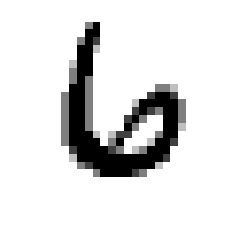

In [9]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

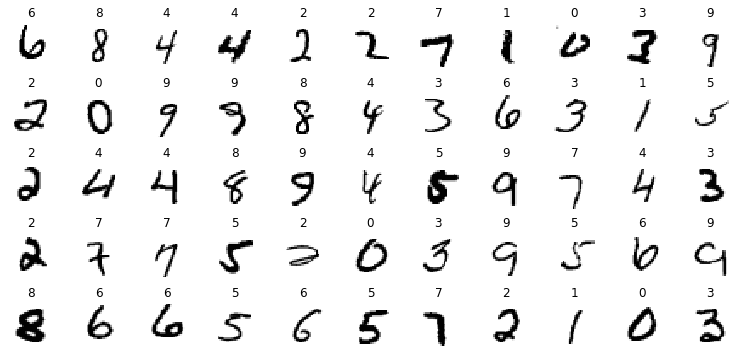

In [10]:
n_rows = 5
n_cols = 11
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off') #this removes the x and y axes values from each plot
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Lets begin by creating a keras backend. Attempting to complete this problem without the ExponentialLearningRate class became difficult. It has since been implemented

In [11]:
K = keras.backend
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
        
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

We begin to add the layers to the model. The first input layer, with 300 neurons, has an input matrix X of m x 300. The weight vector of the hidden layer $W_h$ is 300 * 100. I have kept the activation function of the last layer the same.

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="relu") #If you want to guarantee that the output will always be positive, then you can use the ReLU activation function in the output layer.
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3), #Keras will perform the backprop. algo, & learning rate is .001
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

Lets begin by training the model with three epochs

In [14]:
history = model.fit(X_train, y_train, epochs = 3,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

Epoch 1/3
1313/1313 [==============================] - 2s 1ms/step - loss: 8.2939 - accuracy: 0.0988 - val_loss: 8.3178 - val_accuracy: 0.0943
Epoch 2/3
1313/1313 [==============================] - 2s 1ms/step - loss: 8.3081 - accuracy: 0.0987 - val_loss: 8.3178 - val_accuracy: 0.0943
Epoch 3/3
1313/1313 [==============================] - 2s 1ms/step - loss: 8.3081 - accuracy: 0.0987 - val_loss: 8.3178 - val_accuracy: 0.0943


We see that the loss values decrease with the epochs, but the accuracy does not. The third epoch returned an accuracy rate of 9.8%. A plot of the loss as a function can help us pinpoint an optimal learning rate

Text(0, 0.5, 'Loss')

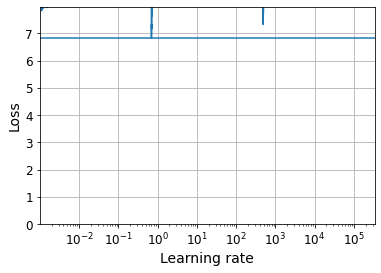

In [16]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

It appears that the Loss values will remain the same at about approximately 7. The learning rates are difficult to interpret.

Let's attempt to use the 'softmax' activation funciton on the output layer. Using the same intial learning rate, .001. Perhaps that gives us a distinct plot.

In [17]:
K = keras.backend
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax") 
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3), #Keras will perform the backprop. algo, & learning rate is .001
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

Epoch 1/3
1313/1313 [==============================] - 2s 1ms/step - loss: 1.0438 - accuracy: 0.6910 - val_loss: 0.4116 - val_accuracy: 0.8706
Epoch 2/3
1313/1313 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.1542 - val_loss: nan - val_accuracy: 0.0957
Epoch 3/3
1313/1313 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0957


Text(0, 0.5, 'Loss')

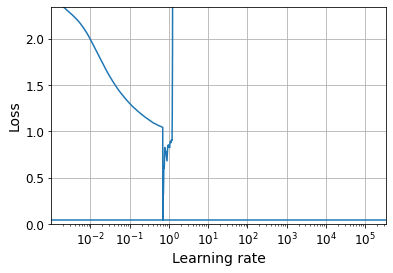

In [18]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

I can comprehend this plot better, as the loss function is decreasing up until approximately 0.5. Then by 0.3, it begins to shoot straight up. However, the accuracy is poor at approximately 10%

Lets reuse this model, but this time, with an initial learning rate of 0.5

In [23]:
K = keras.backend
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax") 
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1), #Keras will perform the backprop. algo, & learning rate is .001
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

Epoch 1/10
1313/1313 [==============================] - 2s 2ms/step - loss: 12.8848 - accuracy: 0.2243 - val_loss: 70.2344 - val_accuracy: 0.1107
Epoch 2/10
1313/1313 [==============================] - 4s 3ms/step - loss: 10264.4062 - accuracy: 0.0979 - val_loss: 70015.5625 - val_accuracy: 0.1006
Epoch 3/10
1313/1313 [==============================] - 5s 4ms/step - loss: 7145004.0000 - accuracy: 0.0976 - val_loss: 41539952.0000 - val_accuracy: 0.0926
Epoch 4/10
1313/1313 [==============================] - 3s 2ms/step - loss: 4996348416.0000 - accuracy: 0.0976 - val_loss: 30543923200.0000 - val_accuracy: 0.1107
Epoch 5/10
1313/1313 [==============================] - 2s 1ms/step - loss: 3451826733056.0000 - accuracy: 0.1006 - val_loss: 27701230436352.0000 - val_accuracy: 0.0957
Epoch 6/10
1313/1313 [==============================] - 2s 1ms/step - loss: 2410736420651008.0000 - accuracy: 0.1010 - val_loss: 17161216141033472.0000 - val_accuracy: 0.1027
Epoch 7/10
1313/1313 [================

The increase in epochs, the addition of a relu layer, and the change in learning rate is still providing the model with an accuracy close to 10%.

In [24]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [32]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20) #Number of epochs with no improvement after which training will be stopped.
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1313/1313 [==============================] - 5s 4ms/step - loss: 3839605366641761873962205184.0000 - accuracy: 0.0999 - val_loss: 3604089734520655851747803136.0000 - val_accuracy: 0.1107
Epoch 2/100
1313/1313 [==============================] - 4s 3ms/step - loss: 3843334560423702996916895744.0000 - accuracy: 0.0991 - val_loss: 4853549691693091446792912896.0000 - val_accuracy: 0.0971
Epoch 3/100
1313/1313 [==============================] - 4s 3ms/step - loss: 3838203709240065127392215040.0000 - accuracy: 0.1002 - val_loss: 3377897234428355226596540416.0000 - val_accuracy: 0.1107
Epoch 4/100
1313/1313 [==============================] - 4s 3ms/step - loss: 3848218667958610927479160832.0000 - accuracy: 0.0987 - val_loss: 5761837264796221474376515584.0000 - val_accuracy: 0.1046
Epoch 5/100
1313/1313 [==============================] - 4s 3ms/step - loss: 3842741313134292497736925184.0000 - accuracy: 0.0995 - val_loss: 4617703198770279370060726272.0000 - val_accuracy: 0.1107
Epoch

In [33]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 595us/step - loss: 1870753528698650187616223232.0000 - accuracy: 0.0892


[1.8707535286986502e+27, 0.08919999748468399]

After different attempts with the number of 'patience epochs', the model with 10 patience epochs returned the highest accuarcy score of approximately 11%. All other attempts stayed at around 9%-10%. 

### Chapter 11 Exercise 8
Practice training a deep neural network on the CIFAR10 image
dataset:

This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. 

#### a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function.

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model2 = keras.models.Sequential()
model2.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for d in range(20):
    model2.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

#### b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_ data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

In [35]:
model2.add(keras.layers.Dense(10, activation='softmax'))

In [36]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5) # momentum optimization
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Model.save(...h5)?
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [37]:
(X_train_full2, y_train_full2), (X_test2, y_test2) = keras.datasets.cifar10.load_data()
print(X_train_full2.shape)
print(y_train_full2.shape)
print()
print(X_test2.shape)
print(y_test2.shape)
print()
print(X_train_full2.dtype)
print(y_train_full2.dtype)

(50000, 32, 32, 3)
(50000, 1)

(10000, 32, 32, 3)
(10000, 1)

uint8
uint8


In [38]:
X_train2, X_valid2 = train_test_split(X_train_full2, train_size=0.7, random_state=4958)

print(X_valid2.shape)
print(X_train2.shape)

# print(X_valid2[0])
# print(X_valid2.dtype)

(15000, 32, 32, 3)
(35000, 32, 32, 3)


In [39]:
y_train2, y_valid2 = train_test_split(y_train_full2, train_size=0.7, random_state=4958)
print(y_valid2.shape)
print(y_train2.shape)

(15000, 1)
(35000, 1)


Switching the patience to 15

In [40]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)

In [41]:
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [1]:
#%tensorboard --logdir=./my_cifar10_logs --port=6006

This model now took approximately 7.1 minutes to fit completely

In [42]:
model2.fit(X_train2, y_train2, epochs=100,
          validation_data=(X_valid2, y_valid2),
          callbacks=callbacks)

Epoch 1/100
1094/1094 [==============================] - 15s 11ms/step - loss: 4.7611 - accuracy: 0.1515 - val_loss: 2.2560 - val_accuracy: 0.1877
Epoch 2/100
1094/1094 [==============================] - 9s 8ms/step - loss: 2.0976 - accuracy: 0.2316 - val_loss: 2.0942 - val_accuracy: 0.2327
Epoch 3/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.9804 - accuracy: 0.2676 - val_loss: 1.9379 - val_accuracy: 0.2857
Epoch 4/100
1094/1094 [==============================] - 11s 10ms/step - loss: 1.9085 - accuracy: 0.2940 - val_loss: 1.8647 - val_accuracy: 0.3167
Epoch 5/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.8553 - accuracy: 0.3177 - val_loss: 1.8512 - val_accuracy: 0.3247
Epoch 6/100
1094/1094 [==============================] - 11s 10ms/step - loss: 1.8129 - accuracy: 0.3373 - val_loss: 1.8170 - val_accuracy: 0.3371
Epoch 7/100
1094/1094 [==============================] - 12s 11ms/step - loss: 1.7698 - accuracy: 0.3504 - val_loss: 1.7

On the 43th epoch, we have the highest accuracy = 0.5469, with a loss score = 1.2543. We can attempt to evaluate this model one more time.

In [43]:
model2 = keras.models.load_model("my_cifar10_model.h5")
model2.evaluate(X_test2, y_test2)
print()

313/313 [==============================] - 1s 2ms/step - loss: 1.5511 - accuracy: 0.4460



The model with the lowest validation loss gets about 44.60% accuracy on the test sets. Every epoch had a duration of anywhere form 5 seconds to 15 seconds.  

In [44]:
model2.evaluate(X_valid2, y_valid2)

469/469 [==============================] - 1s 2ms/step - loss: 1.5659 - accuracy: 0.4458


[1.5659033060073853, 0.4458000063896179]

The model with the lowest validation loss gets approximately 44.58% accuracy on the validations sets.

#### c. Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

In [45]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#### The following code took approximately 8 minutes to complete

In [48]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model3.add(keras.layers.BatchNormalization())
for _ in range(20):
    model3.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model3.add(keras.layers.BatchNormalization())
    model3.add(keras.layers.Activation("elu"))
model3.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model3.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
model3_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model3.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model3_checkpoint_cb, tensorboard_cb]

model3.fit(X_train2, y_train2, epochs=100,
          validation_data=(X_valid2, y_valid2),
          callbacks=callbacks)

Epoch 1/100
1094/1094 [==============================] - 31s 22ms/step - loss: 1.8720 - accuracy: 0.3299 - val_loss: 1.7024 - val_accuracy: 0.3936
Epoch 2/100
1094/1094 [==============================] - 15s 14ms/step - loss: 1.6841 - accuracy: 0.4006 - val_loss: 1.6123 - val_accuracy: 0.4298
Epoch 3/100
1094/1094 [==============================] - 16s 14ms/step - loss: 1.6141 - accuracy: 0.4259 - val_loss: 1.5426 - val_accuracy: 0.4541
Epoch 4/100
1094/1094 [==============================] - 16s 14ms/step - loss: 1.5563 - accuracy: 0.4467 - val_loss: 1.5199 - val_accuracy: 0.4563
Epoch 5/100
1094/1094 [==============================] - 15s 14ms/step - loss: 1.5230 - accuracy: 0.4589 - val_loss: 1.4942 - val_accuracy: 0.4697
Epoch 6/100
1094/1094 [==============================] - 14s 13ms/step - loss: 1.4903 - accuracy: 0.4718 - val_loss: 1.4602 - val_accuracy: 0.4791
Epoch 7/100
1094/1094 [==============================] - 9s 8ms/step - loss: 1.4540 - accuracy: 0.4837 - val_loss: 1.4

[1.3824894428253174, 0.5223333239555359]

In [49]:
model3 = keras.models.load_model("my_cifar10_bn_model3.h5")
model3.evaluate(X_valid2, y_valid2)

469/469 [==============================] - 3s 5ms/step - loss: 1.3825 - accuracy: 0.5223


[1.3824894428253174, 0.5223333239555359]

In [50]:
model3.evaluate(X_test2, y_test2)

313/313 [==============================] - 2s 6ms/step - loss: 1.3624 - accuracy: 0.5268


[1.3623976707458496, 0.5267999768257141]

* Q: Is it converging faster than before? 
    + A: Although this model took longer to fit in terms of minutes and seconds. It did converge in 32 epochs, which is less when compared to the model in B.
* Q: Does it produce a better model?
    + A: In terms of validation score, this model improved with a score of approximately 52.68%
* Q: How does it affect training speed?
    + A: Every epoch took around 9-12 seconds to complete. This can be due to the extra calculations required with the Batch Normilazation layer. 